# Random Forest

## PACE Single Day

(405, 93, 163, 172)


/var/folders/sg/s2pmpvfj42b35zzctr2whzcr0000gn/T/ipykernel_68552/1972100356.py:40: RuntimeWarning: Mean of empty slice
  data_flat = np.nanmean(ndarray_all, axis=(1, 2))  # shape (n, c)


Data shape (after masking): (215, 172)
Labels shape: (215,)
Dates shape: (215,)
[[-2.3036799e-03 -2.0480568e-03 -1.7953771e-03 ...  5.3680232e-03
   4.6585016e-03  4.3228683e-03]
 [ 1.5699262e-03  1.9994942e-03  2.2910424e-03 ...  3.9135306e-03
   3.4755785e-03  3.2161900e-03]
 [ 6.5488038e-03  6.6216746e-03  6.7013116e-03 ...  4.6397825e-03
   4.0858067e-03  3.8033377e-03]
 ...
 [ 3.6760634e-03  3.7517629e-03  3.8014855e-03 ...  3.6310258e-03
   3.1256245e-03  2.8579044e-03]
 [ 2.7580594e-03  3.0080893e-03  3.1714772e-03 ...  2.2357279e-03
   1.9406852e-03  1.7913989e-03]
 [-6.9099246e-04 -2.8259496e-04 -6.2855652e-05 ...  1.7099938e-03
   1.4439132e-03  1.3625810e-03]]

Original StratifiedKFold ROC-AUC scores: [0.83116883 0.83549784 0.9004329  0.89393939 0.6017316 ]
Mean ROC-AUC: 0.8125541125541126

Shuffled StratifiedKFold ROC-AUC scores: [0.87445887 0.95021645 0.89177489 0.80735931 0.85714286]
Mean ROC-AUC on shuffled data: 0.8761904761904761

Confusion Matrix (Threshold = 0.5):
[[

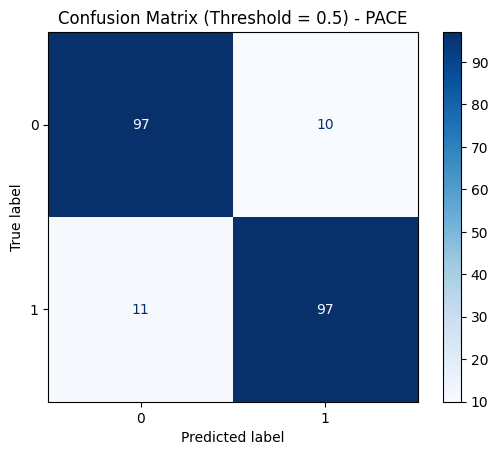

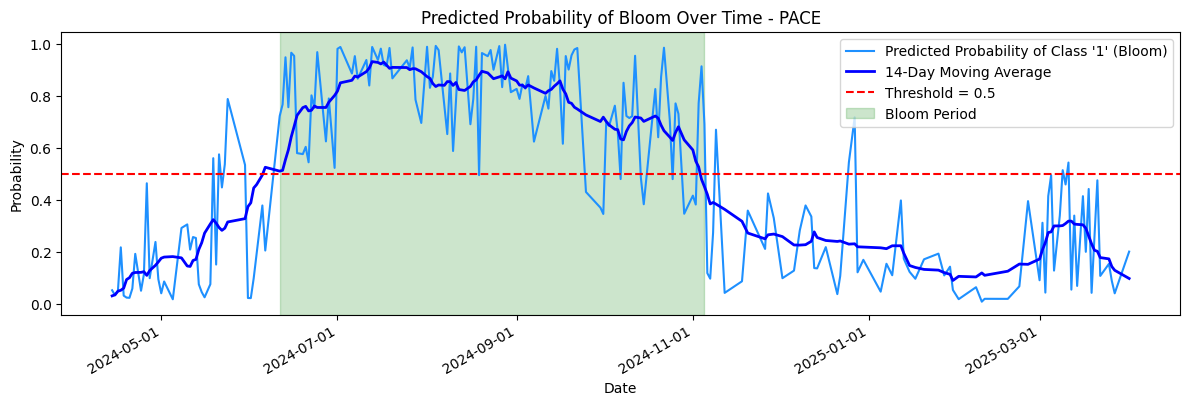

In [22]:
import numpy as np
import pickle
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Load data
ndarray_all = np.load("../../Images/composite_data_PACE.npy")  # shape (n, h, w, c)

print(ndarray_all.shape)

with open("../../Images/composite_metadata_PACE.pkl", "rb") as f:
    metadata = pickle.load(f)
wave_all = metadata["wavelengths"]

# Get dates from metadata, or fallback to estimate from known start date
if "dates" in metadata:
    dates = np.array(metadata["dates"])
    dates = np.array([datetime.strptime(d, "%Y-%m-%d") if isinstance(d, str) else d for d in dates])
else:
    start_date = datetime(2024, 4, 14)  # Your known start date
    n = ndarray_all.shape[0]
    dates = np.array([start_date + timedelta(days=i) for i in range(n)])

# Create labels based on date ranges
label_1_start = datetime(2024, 6, 11)
label_1_end = datetime(2024, 11, 5)

# Decision threshold
decision_threshold = 0.5

labels = np.array([1 if (label_1_start <= d <= label_1_end) else 0 for d in dates])

# Average over spatial dimensions (h, w)
data_flat = np.nanmean(ndarray_all, axis=(1, 2))  # shape (n, c)

# Remove days with all NaNs
valid_days_mask = ~np.isnan(data_flat).all(axis=1)
data_flat = data_flat[valid_days_mask]
labels = labels[valid_days_mask]
dates = dates[valid_days_mask]

# Print shapes for sanity check
print("Data shape (after masking):", data_flat.shape)
print("Labels shape:", labels.shape)
print("Dates shape:", dates.shape)

# Handle NaNs by replacing them with column means
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data_flat)

print(data_imputed)

# ------------------------------
# Cross-validation on original data (StratifiedKFold)
model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    min_samples_leaf=5, 
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=False)
scores = cross_val_score(model, data_imputed, labels, cv=cv, scoring='roc_auc')

print("\nOriginal StratifiedKFold ROC-AUC scores:", scores)
print("Mean ROC-AUC:", scores.mean())

# ------------------------------
# Shuffle features and labels in unison
data_shuffled, labels_shuffled = shuffle(data_imputed, labels, random_state=42)

# Cross-validation on shuffled data (StratifiedKFold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
shuffled_scores = cross_val_score(model, data_shuffled, labels_shuffled, cv=cv, scoring='roc_auc')
print("\nShuffled StratifiedKFold ROC-AUC scores:", shuffled_scores)
print("Mean ROC-AUC on shuffled data:", shuffled_scores.mean())

# ------------------------------
# Train final model on original (time-ordered) data
model.fit(data_imputed, labels)

# Predict probabilities
y_prob = model.predict_proba(data_imputed)[:, 1]

# Confusion matrix from thresholded predictions (optional)
y_pred = (y_prob >= decision_threshold).astype(int)
cm = confusion_matrix(labels, y_pred)
print(f"\nConfusion Matrix (Threshold = {decision_threshold}):")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(labels, y_pred, digits=4))

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Threshold = 0.5) - PACE")
plt.show()

# Calculate a 7-day moving average (adjust window as needed)
window_size = 14
y_prob_ma = np.convolve(y_prob, np.ones(window_size) / window_size, mode='same')

# Plot probabilities over time
plt.figure(figsize=(12, 4))

# Original predicted probabilities
plt.plot(dates, y_prob, color = 'dodgerblue', label="Predicted Probability of Class '1' (Bloom)")

# Moving average with thicker indigo line
plt.plot(dates, y_prob_ma, color='blue', linewidth=2, label=f"{window_size}-Day Moving Average")

# Add dashed red horizontal line at threshold 0.5
plt.axhline(y=decision_threshold, color='red', linestyle='--', label=f"Threshold = {decision_threshold}")

# Shade the green 'label 1' region
plt.axvspan(label_1_start, label_1_end, color='green', alpha=0.2, label='Bloom Period')

# Labels and formatting
plt.xlabel("Date")
plt.ylabel("Probability")
plt.title("Predicted Probability of Bloom Over Time - PACE")
plt.legend()
plt.tight_layout()

# Optional: Format x-axis date ticks for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()


## Sentinel-3 Single Day

(405, 93, 163, 21)


/var/folders/sg/s2pmpvfj42b35zzctr2whzcr0000gn/T/ipykernel_68552/3646507047.py:38: RuntimeWarning: Mean of empty slice
  data_flat = np.nanmean(ndarray_all, axis=(1, 2))  # shape (n, c)
/Users/jessecox/.pyenv/versions/3.11.2/lib/python3.11/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [11 12 13 14 15 16 17 18 19 20]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Data shape (after masking): (287, 21)
Labels shape: (287,)
Dates shape: (287,)
[[0.00682453 0.00799797 0.0108903  ... 0.01175316 0.0116519  0.00881627]
 [0.00785309 0.00920529 0.01192999 ... 0.00896752 0.00881405 0.00614312]
 [0.00674751 0.00789688 0.01055617 ... 0.00676279 0.00659706 0.00427003]
 ...
 [0.02808443 0.02501602 0.01899861 ... 0.00319627 0.00307649 0.0013542 ]
 [0.0038505  0.00514364 0.00757852 ... 0.00528385 0.00519436 0.00331246]
 [0.00494158 0.00599333 0.00825985 ... 0.00659021 0.00652039 0.0044251 ]]

Original StratifiedKFold ROC-AUC scores: [0.78485577 0.83632019 0.99627792 0.77419355 0.85980149]
Mean ROC-AUC: 0.8502897826486537

Shuffled StratifiedKFold ROC-AUC scores: [0.82932692 0.91039427 0.90198511 0.81389578 0.85856079]
Mean ROC-AUC on shuffled data: 0.8628325751309622

Confusion Matrix (Threshold = 0.5):
[[138  18]
 [ 17 114]]

Classification Report:
              precision    recall  f1-score   support

           0     0.8903    0.8846    0.8875       156
   

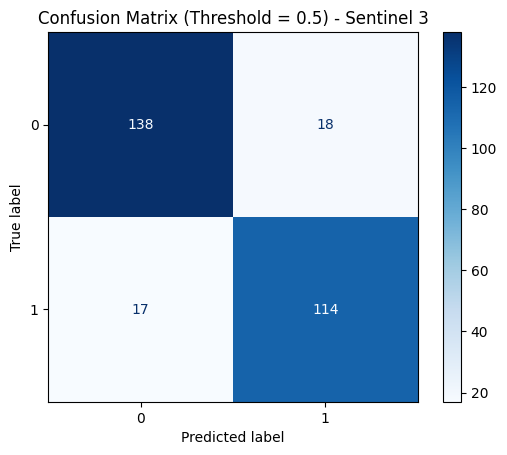

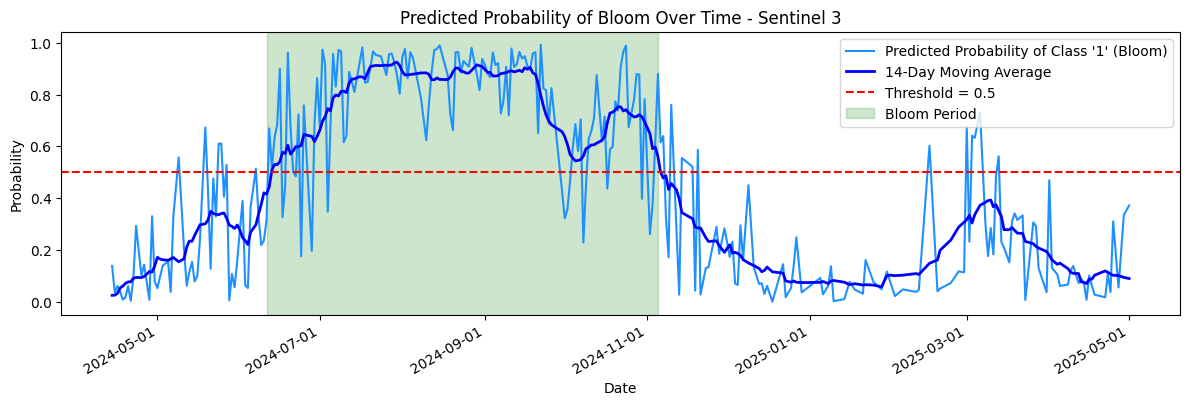

In [23]:
import numpy as np
import pickle
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
ndarray_all = np.load("../../Images/composite_data_S3.npy")  # shape (n, h, w, c)
print(ndarray_all.shape)

with open("../../Images/composite_metadata_S3.pkl", "rb") as f:
    metadata = pickle.load(f)
wave_all = metadata["wavelengths"]

# Get dates from metadata, or fallback to estimate from known start date
if "dates" in metadata:
    dates = np.array(metadata["dates"])
    dates = np.array([datetime.strptime(d, "%Y-%m-%d") if isinstance(d, str) else d for d in dates])
else:
    start_date = datetime(2024, 4, 14)  # Your known start date
    n = ndarray_all.shape[0]
    dates = np.array([start_date + timedelta(days=i) for i in range(n)])

# Create labels based on date ranges
label_1_start = datetime(2024, 6, 11)
label_1_end = datetime(2024, 11, 5)

# Decision threshold
decision_threshold = 0.5

labels = np.array([1 if (label_1_start <= d <= label_1_end) else 0 for d in dates])

# Average over spatial dimensions (h, w)
data_flat = np.nanmean(ndarray_all, axis=(1, 2))  # shape (n, c)

# Remove days with all NaNs
valid_days_mask = ~np.isnan(data_flat).all(axis=1)
data_flat = data_flat[valid_days_mask]
labels = labels[valid_days_mask]
dates = dates[valid_days_mask]

# Print shapes for sanity check
print("Data shape (after masking):", data_flat.shape)
print("Labels shape:", labels.shape)
print("Dates shape:", dates.shape)

# Handle NaNs by replacing them with column means
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data_flat)

print(data_imputed)

# ------------------------------
# Cross-validation on original data (StratifiedKFold)
model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    min_samples_leaf=5, 
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=False)
scores = cross_val_score(model, data_imputed, labels, cv=cv, scoring='roc_auc')

print("\nOriginal StratifiedKFold ROC-AUC scores:", scores)
print("Mean ROC-AUC:", scores.mean())

# ------------------------------
# Shuffle features and labels in unison
data_shuffled, labels_shuffled = shuffle(data_imputed, labels, random_state=42)

# Cross-validation on shuffled data (StratifiedKFold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
shuffled_scores = cross_val_score(model, data_shuffled, labels_shuffled, cv=cv, scoring='roc_auc')
print("\nShuffled StratifiedKFold ROC-AUC scores:", shuffled_scores)
print("Mean ROC-AUC on shuffled data:", shuffled_scores.mean())

# ------------------------------
# Train final model on original (time-ordered) data
model.fit(data_imputed, labels)

# Predict probabilities
y_prob = model.predict_proba(data_imputed)[:, 1]

# Confusion matrix from thresholded predictions (optional)
y_pred = (y_prob >= decision_threshold).astype(int)
cm = confusion_matrix(labels, y_pred)
print(f"\nConfusion Matrix (Threshold = {decision_threshold}):")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(labels, y_pred, digits=4))

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Threshold = 0.5) - Sentinel 3")
plt.show()

# -------------------------------------
# 📊 Plot probabilities over time with moving average
# Calculate a 14-day moving average (adjust window as needed)
window_size = 14
y_prob_ma = np.convolve(y_prob, np.ones(window_size) / window_size, mode='same')

plt.figure(figsize=(12, 4))
plt.plot(dates, y_prob, color = 'dodgerblue', label="Predicted Probability of Class '1' (Bloom)")

# Moving average with thicker indigo line
plt.plot(dates, y_prob_ma, color='blue', linewidth=2, label=f"{window_size}-Day Moving Average")

# Add dashed red horizontal line at threshold 0.5
plt.axhline(y=decision_threshold, color='red', linestyle='--', label=f"Threshold = {decision_threshold}")

# Shade the green 'label 1' region
plt.axvspan(label_1_start, label_1_end, color='green', alpha=0.2, label='Bloom Period')

# Labels and formatting
plt.xlabel("Date")
plt.ylabel("Probability")
plt.title("Predicted Probability of Bloom Over Time - Sentinel 3")
plt.legend()
plt.tight_layout()

# Optional: Format x-axis date ticks for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()


## PACE 7-Day

(405, 93, 163, 172)


/var/folders/sg/s2pmpvfj42b35zzctr2whzcr0000gn/T/ipykernel_68552/312524240.py:40: RuntimeWarning: Mean of empty slice
  data_flat = np.nanmean(ndarray_all, axis=(1, 2))  # shape (n, c)


Data shape (after masking): (359, 172)
Labels shape: (359,)
Dates shape: (359,)
[[ 9.7254670e-04  1.1806728e-03  1.4089056e-03 ...  5.8082798e-03
   5.0863437e-03  4.6318686e-03]
 [-5.0250208e-04 -2.7325057e-04 -2.9379929e-05 ...  6.1416076e-03
   5.3346264e-03  4.8503582e-03]
 [ 9.9584773e-05  3.9202027e-04  6.5091264e-04 ...  5.5235587e-03
   4.8213629e-03  4.4012303e-03]
 ...
 [-6.9099234e-04 -2.8259456e-04 -6.2855856e-05 ...  1.7099935e-03
   1.4439129e-03  1.3625806e-03]
 [-6.9099234e-04 -2.8259491e-04 -6.2855768e-05 ...  1.7099935e-03
   1.4439125e-03  1.3625806e-03]
 [-6.9099246e-04 -2.8259508e-04 -6.2855652e-05 ...  1.7099938e-03
   1.4439132e-03  1.3625810e-03]]

Original StratifiedKFold ROC-AUC scores: [0.82919006 0.99325397 0.99444444 0.8984127  0.67980296]
Mean ROC-AUC: 0.8790208245821718

Shuffled StratifiedKFold ROC-AUC scores: [0.92702486 0.96984127 0.98492063 0.98095238 0.96059113]
Mean ROC-AUC on shuffled data: 0.9646660556764808

Confusion Matrix (Threshold = 0.5):
[[

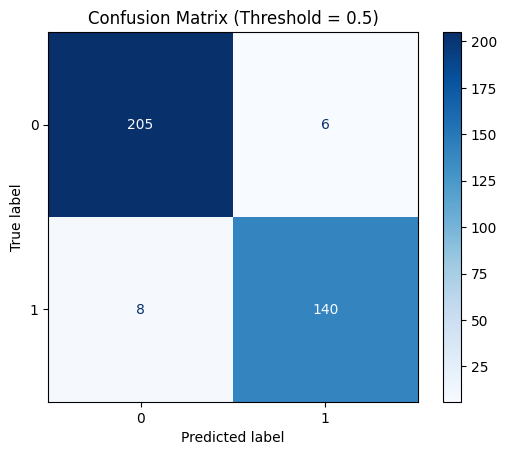

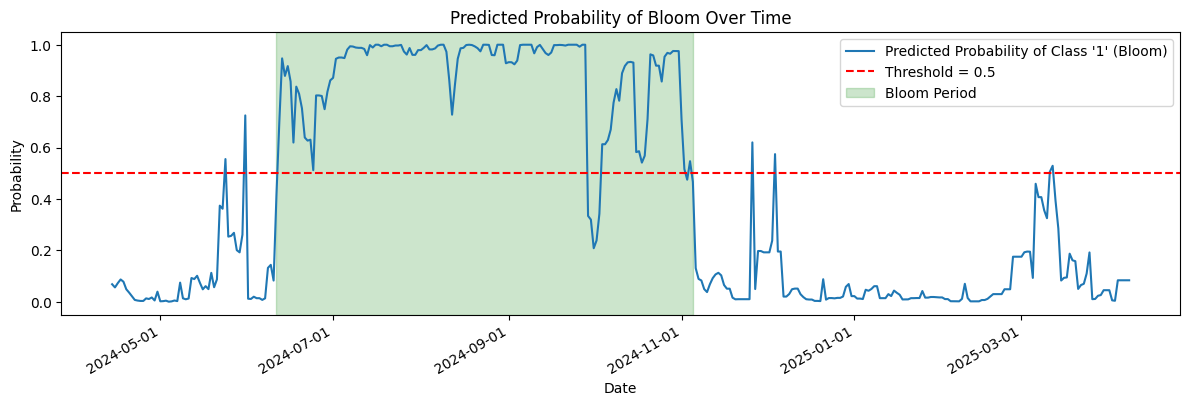

In [6]:
import numpy as np
import pickle
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Load data
ndarray_all = np.load("../../Images/composite_data_PACE_full.npy")  # shape (n, h, w, c)

print(ndarray_all.shape)

with open("../../Images/composite_metadata_PACE.pkl", "rb") as f:
    metadata = pickle.load(f)
wave_all = metadata["wavelengths"]

# Get dates from metadata, or fallback to estimate from known start date
if "dates" in metadata:
    dates = np.array(metadata["dates"])
    dates = np.array([datetime.strptime(d, "%Y-%m-%d") if isinstance(d, str) else d for d in dates])
else:
    start_date = datetime(2024, 4, 14)  # Your known start date
    n = ndarray_all.shape[0]
    dates = np.array([start_date + timedelta(days=i) for i in range(n)])

# Create labels based on date ranges
label_1_start = datetime(2024, 6, 11)
label_1_end = datetime(2024, 11, 5)

# Decision threshold
decision_threshold = 0.5

labels = np.array([1 if (label_1_start <= d <= label_1_end) else 0 for d in dates])

# Average over spatial dimensions (h, w)
data_flat = np.nanmean(ndarray_all, axis=(1, 2))  # shape (n, c)

# Remove days with all NaNs
valid_days_mask = ~np.isnan(data_flat).all(axis=1)
data_flat = data_flat[valid_days_mask]
labels = labels[valid_days_mask]
dates = dates[valid_days_mask]

# Print shapes for sanity check
print("Data shape (after masking):", data_flat.shape)
print("Labels shape:", labels.shape)
print("Dates shape:", dates.shape)

# Handle NaNs by replacing them with column means
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
data_imputed = imputer.fit_transform(data_flat)

print(data_imputed)

# ------------------------------
# Cross-validation on original data (StratifiedKFold)
model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=10, 
    min_samples_leaf=5, 
    random_state=42
)

cv = StratifiedKFold(n_splits=5, shuffle=False)
scores = cross_val_score(model, data_imputed, labels, cv=cv, scoring='roc_auc')

print("\nOriginal StratifiedKFold ROC-AUC scores:", scores)
print("Mean ROC-AUC:", scores.mean())

# ------------------------------
# Shuffle features and labels in unison
data_shuffled, labels_shuffled = shuffle(data_imputed, labels, random_state=42)

# Cross-validation on shuffled data (StratifiedKFold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
shuffled_scores = cross_val_score(model, data_shuffled, labels_shuffled, cv=cv, scoring='roc_auc')
print("\nShuffled StratifiedKFold ROC-AUC scores:", shuffled_scores)
print("Mean ROC-AUC on shuffled data:", shuffled_scores.mean())

# ------------------------------
# Train final model on original (time-ordered) data
model.fit(data_imputed, labels)

# Predict probabilities
y_prob = model.predict_proba(data_imputed)[:, 1]

# Confusion matrix from thresholded predictions (optional)
y_pred = (y_prob >= decision_threshold).astype(int)
cm = confusion_matrix(labels, y_pred)
print(f"\nConfusion Matrix (Threshold = {decision_threshold}):")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(labels, y_pred, digits=4))

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Threshold = 0.5)")
plt.show()

# Plot probabilities over time
plt.figure(figsize=(12, 4))
plt.plot(dates, y_prob, label="Predicted Probability of Class '1' (Bloom)")

# Add dashed red horizontal line at threshold 0.5
plt.axhline(y=decision_threshold, color='red', linestyle='--', label=f"Threshold = {decision_threshold}")

# Shade the green 'label 1' region
plt.axvspan(label_1_start, label_1_end, color='green', alpha=0.2, label='Bloom Period')

# Labels and formatting
plt.xlabel("Date")
plt.ylabel("Probability")
plt.title("Predicted Probability of Bloom Over Time")
plt.legend()
plt.tight_layout()

# Optional: Format x-axis date ticks for better readability
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate()

plt.show()
